In [1]:
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, disk
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from scipy.ndimage import binary_fill_holes
from skimage.transform import resize

import nibabel as nib
import os
import matplotlib.pyplot as plt

In [2]:
def get_crop_coords_mri_patient_single(path_to_image: str, path_to_label: str, vol_size = [128, 128, 128]): 
    '''
    Takes the path to an MRI image and its corresponding label, and computes the coordinetes of the original 3D volume
    after cropping it to vol_size.
    This should be a direct preprocessing step in a training pipeline.
    The coordinates for the cropped volume and corresponding label are centered in the original volume and shifted up 20 pixels.
    
    Parameters:
    path_to_image (str): The path to the MRI image.
    path_to_label (str): The path to the corresponding label. Binary mask.
    vol_size (list): The size of the cropped volume. Default is [60, 80, 80].

    returns:
    coords (list): The coordinates of the cropped volume in the original volume.
    
    '''
    print(path_to_image, path_to_label)
    # Load the image and label
    img = nib.load(path_to_image)
    label = nib.load(path_to_label)

    # Get the data
    img_data = img.get_fdata()
    label_data = label.get_fdata()

    # From the centre of the entire volume, crop the volume to vol_size
    x, y, z = img_data.shape
    xx, yy, zz = label_data.shape

    # Check if the image and label have the same size
    if x != xx or y != yy or z != zz:
        raise ValueError('The image and label do not have the same size.')

    # Compute the coordinates for the cropped volume and shift it up in the x-direction
    x_start = int(x/2 - vol_size[0]/2) 
    x_end = int(x/2 + vol_size[0]/2) 
    y_start = int(y/2 - vol_size[1]/2) - 16
    y_end = int(y/2 + vol_size[1]/2) - 16
    z_start = int(z/2 - vol_size[2]/2) + 32
    z_end = int(z/2 + vol_size[2]/2) + 32

    # return the coordinates of the cropped volume in the original volume
    coords = [x_start, x_end, y_start, y_end, z_start, z_end]

    return coords

    

def crop_mri_patient_multiple(subject_folder: str, img_name:str = 'co_FLAIR.nii', label_name:str = 'mask.nii', vol_size = [128, 128, 128]):
    '''
    Calls fun crop_mri_patient_single for all MRI images in a folder.

    For each MRI image in the folder, the function computes the coordinates of the original 3D volume
      (where the MRI image is) after cropping it to vol_size.

    Parameters:
    subject_folder (str): The path to the folder containing the MRI images.
    img_name (str): The name of the MRI image file. Default is 'co_FLAIR.nii'.
    label_name (str): The name of the label file. Default is 'mask.nii'.
    vol_size (list): The size of the cropped volume. Default is [128, 128, 128].

    returns:
    coords_list (list): A list of coordinates of the cropped volumes in the original volumes of all MRI images in the folder.

    '''

    coords_list = []
    subjects = os.listdir(subject_folder)
    if '.DS_Store' in subjects:
        subjects.remove('.DS_Store')
    
    for subject in subjects:
        path_to_image = os.path.join(subject_folder, subject, img_name)
        path_to_label = os.path.join(subject_folder, subject, label_name)
        coords = get_crop_coords_mri_patient_single(path_to_image, path_to_label, vol_size = vol_size)
        coords_list.append(coords)
    
    return coords_list


def load_img_and_label_crop_and_display(subject_folder:str, 
                                        img_name:str = 'co_FLAIR.nii', label_name:str = 'mask.nii', 
                                        vol_size= [128, 128, 128], 
                                        save_crop = False):
    '''
    Loads the MRI image and label, crops them to vol_size and displays them.
    The function is used to check if the cropping is done correctly.

    Parameters:
    subject_folder (str): The path to the folder containing the MRI images.
    img_name (str): The name of the MRI image file. Default is 'co_FLAIR.nii'.
    label_name (str): The name of the label file. Default is 'mask.nii'.
    vol_size (list): The size of the cropped volume. Default is [128, 128, 128].
    save_crop (bool): If True, the cropped image and label are saved in the subject folder. Default is False.

    '''

    coords_list = crop_mri_patient_multiple(subject_folder, img_name, label_name, vol_size)
    subjects = os.listdir(subject_folder)
    # for each subject, cut out a part and display one slice. 
    # The plot should contain a slice of each subject and its corresponding label.

    if '.DS_Store' in subjects:
        subjects.remove('.DS_Store')

    for i, subject in enumerate(subjects):
        # Load the image and label
        path_to_image = os.path.join(subject_folder, subject, img_name)
        path_to_label = os.path.join(subject_folder, subject, label_name)
        print(path_to_image, path_to_label)
        img = nib.load(path_to_image)
        label = nib.load(path_to_label)
        img_data = img.get_fdata()
        label_data = label.get_fdata()
        coords = coords_list[i]
        # Crop the image and label
        img_data = img_data[coords[0]:coords[1], coords[2]:coords[3], coords[4]:coords[5]]
        label_data = label_data[coords[0]:coords[1], coords[2]:coords[3], coords[4]:coords[5]]
        # Save the cropped image and label
        img = nib.Nifti1Image(img_data, img.affine)
        label = nib.Nifti1Image(label_data, label.affine)
        if save_crop:
            print('Saving cropped image and label to file',  os.path.join(subject_folder, subject, 'cropped_' + img_name))
            nib.save(img, os.path.join(subject_folder, subject, 'cropped_' + img_name))
            nib.save(label, os.path.join(subject_folder, subject, 'cropped_' + label_name))

        # Display the image and label
        _, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(img_data[:,:,55], cmap='gray')
        ax[0].set_title('MRI Image')
        ax[0].axis('off')
        ax[1].imshow(label_data[:,:,55], cmap='gray')
        ax[1].set_title('Label')
        ax[1].axis('off')
        plt.show()
        
    return 

    

    

/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/18/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/18/mask.nii
/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/9/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/9/mask.nii
/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/0/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/0/mask.nii
/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/11/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/11/mask.nii
/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/7/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/7/mask.nii
/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/16/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/16/mask.nii
/Users/user/Documents/projects_/project_dir/da

/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/9/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/9/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/9/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/0/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/0/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/0/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/11/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/11/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/11/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/7/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/7/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/7/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/16/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/16/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/16/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/6/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/6/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/6/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/17/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/17/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/17/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/1/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/1/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/1/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/10/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/10/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/10/cropped_co_FLAIR.nii


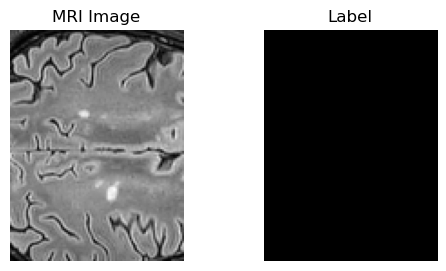

/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/19/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/19/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/19/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/8/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/8/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/8/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/4/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/4/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/4/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/15/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/15/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/15/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/3/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/3/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/3/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/12/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/12/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/12/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/2/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/2/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/2/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/13/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/13/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/13/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/5/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/5/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/5/cropped_co_FLAIR.nii


/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/14/co_FLAIR.nii /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/14/mask.nii
Saving cropped image and label to file /Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/14/cropped_co_FLAIR.nii


In [15]:
subject_folder="/var/data/MONAI_Choroid_Plexus/ANON_DATA_01_labels/"
subject_folder="/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/"

subject_folder="/var/data/MONAI_Choroid_Plexus/ANON_DATA_01_labels/"
subject_folder="/Users/user/Documents/projects_/project_dir/data/ANON_FLAIR_COREG/"

load_img_and_label_crop_and_display(subject_folder, vol_size= [128, 96, 96], save_crop=False)


In [ ]:
def put_crop_back_to_original_size(cropped_label, coords, original_size, save_prediction = False):
    '''
    Brings a cropped 3d label back to its original size. 
    If it is a label, it fills the holes in the label with zeros.


    Parameters:
    cropped_label (np.array or torch.tensor): The cropped label.
    coords (list): The coordinates of the cropped volume in the original volume.
    original_size (list): The original size of the image.
    save_prediction (bool): If True, the prediction with the original size is saved. Default is False.

    returns:
    image (np.array or torch.tensor): The label in the original size.

    '''
    # Get the original size of the image
    x, y, z = original_size

    # Get the coordinates of the cropped volume
    x_start, x_end, y_start, y_end, z_start, z_end = coords

    # Create an empty image with the original size
    label_orig_size = np.zeros((x, y, z))

    # Fill the cropped image into the empty image
    label_orig_size[x_start:x_end, y_start:y_end, z_start:z_end] = cropped_label

    # Save prediction with original size (use identity affine matrix to avoid resampling)
    if save_prediction:
        nib.save(nib.Nifti1Image(label_orig_size, np.eye(4)), 'prediction_orig_size.nii')

    return label_orig_size







### Cropping Class

In [ ]:
import torch
import numpy as np
import nibabel as nib

class CropMRI(torch.nn.Module):
    def __init__(self, vol_size=[128, 128, 128]):
        super(CropMRI, self).__init__()
        self.vol_size = vol_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # Get the data
        img_data = image.get_fdata()
        label_data = label.get_fdata()

        # From the centre of the entire volume, crop the volume to vol_size
        x, y, z = img_data.shape
        xx, yy, zz = label_data.shape

        # Check if the image and label have the same size
        if x != xx or y != yy or z != zz:
            raise ValueError('The image and label do not have the same size.')

        # Compute the coordinates for the cropped volume and shift it up in the x-direction
        x_start = int(x/2 - self.vol_size[0]/2) 
        x_end = int(x/2 + self.vol_size[0]/2) 
        y_start = int(y/2 - self.vol_size[1]/2) - 16
        y_end = int(y/2 + self.vol_size[1]/2) - 16
        z_start = int(z/2 - self.vol_size[2]/2) + 32
        z_end = int(z/2 + self.vol_size[2]/2) + 32

        # Crop the image and label
        img_data = img_data[x_start:x_end, y_start:y_end, z_start:z_end]
        label_data = label_data[x_start:x_end, y_start:y_end, z_start:z_end]

        # Convert the numpy arrays to PyTorch tensors
        img_data = torch.from_numpy(img_data)
        label_data = torch.from_numpy(label_data)

        return {'image': img_data, 'label': label_data}

### Cropping with MONAI
fixed cropping followed by a random cropping within the initially fixed cropped region,

In [4]:
from monai.transforms import Compose, LoadImaged, SpatialCropd, RandSpatialCropd, EnsureTyped, EnsureChannelFirstd


In [ ]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    SpatialCropd(keys=["image", "label"], roi_start= (26, 48, 80), roi_end=(154, 176, 208)),
    RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64), random_size=False),
    EnsureTyped(keys=["image", "label"]),
])


In [ ]:
from monai.data import DataLoader, Dataset

train_files = [{"image": "path/to/image1.nii", "label": "path/to/label1.nii"}, ...]
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
